Restarted ProjectEnv (Python 3.12.4)

In [ ]:
import torchsummary as summary
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adamw import AdamW
from data.config import *
from data.utils import *
# from data.dataset import MixtureDataset, AudioMixtureDataset
from data.dataset import AudioDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from metrics_loss import *
from model.base import Base
# load neccessary metrics/confusion matrix for multilabel classification
from sklearn.metrics import multilabel_confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# mp.set_start_method('spawn', force=True)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'


class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 3, kernel_size=1, padding=0),
        )

        # self.classifier = nn.Sequential(
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),
        #     nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     nn.ReLU(),

        #     # Linear
        #     nn.Flatten(),
        #     nn.Linear(out_c*2 * 8 * 30, out_c*2),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c*2, out_c),
        #     nn.ReLU(),
        #     nn.Dropout(0.3),
        #     nn.Linear(out_c, 8)
        # )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(4, 4),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),

            nn.Flatten(),
            # nn.Linear(out_c*4 * 16 * 61, 128),
            # nn.Linear(out_c*4 * 8 * 30, 128),
            nn.Linear(out_c*2 * 4 * 15, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 8)
        )

    def forward(self, x):

        x = x.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        output = self.output(decoder3)

        output_masks_dict = {
            'mag_mask': torch.sigmoid(output[:, 0, :, :]),
            'real_mask': torch.tanh(output[:, 1, :, :]),
            'imag_mask': torch.tanh(output[:, 2, :, :])
        }

        class_output = self.classifier(skip3)
        # return output, class_output

        return output_masks_dict, class_output

class ResUNetv2(nn.Module, Base):
    def __init__(self, in_c, out_c):
        super(ResUNetv2, self).__init__()

        window_size = 256
        hop_size = 64
        center = True
        pad_mode = "reflect"
        window = "hann"

        self.output_channels = 1
        # self.target_sources_num = 1
        self.K = 3

        # downsample ratio
        self.time_downsample_ratio = 2**3  # number of encoder layers

        self.stft = STFT(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True,
        )

        self.istft = ISTFT(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True,
        )

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)
        # self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding="same"),

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        # self.last_layer = nn.Sequential(
        #     # nn.Conv2d(out_c, 1, kernel_size=1, padding='same'),
        #     nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
        # )

        self.after_conv = nn.Conv2d(
            in_channels=out_c,
            out_channels=self.output_channels * self.K,
            kernel_size=(1, 1),
            stride=(1, 1),
            padding=(0, 0),
            bias=True,
        )

    def feature_maps_to_wav(
        self,
        input_tensor: torch.Tensor,
        sp: torch.Tensor,
        sin_in: torch.Tensor,
        cos_in: torch.Tensor,
        audio_length: int,
    ) -> torch.Tensor:
        r"""Convert feature maps to waveform.

        Args:
            input_tensor: (batch_size, target_sources_num * output_channels * self.K, time_steps, freq_bins)
            sp: (batch_size, input_channels, time_steps, freq_bins)
            sin_in: (batch_size, input_channels, time_steps, freq_bins)
            cos_in: (batch_size, input_channels, time_steps, freq_bins)

            (There is input_channels == output_channels for the source separation task.)

        Outputs:
            waveform: (batch_size, target_sources_num * output_channels, segment_samples)
        """
        batch_size, _, time_steps, freq_bins = input_tensor.shape

        x = input_tensor.reshape(
            batch_size,
            # self.target_sources_num,
            self.output_channels,
            self.K,
            time_steps,
            freq_bins,
        )
        # x: (batch_size, target_sources_num, output_channels, self.K, time_steps, freq_bins)

        # mask_mag = torch.sigmoid(x[:, :, :, 0, :, :])
        # _mask_real = torch.tanh(x[:, :, :, 1, :, :])
        # _mask_imag = torch.tanh(x[:, :, :, 2, :, :])
        
        mask_mag = torch.sigmoid(x[:, :, 0, :, :])
        _mask_real = torch.tanh(x[:, :, 1, :, :])
        _mask_imag = torch.tanh(x[:, :, 2, :, :])
        # print(mask_mag.shape)
        # linear_mag = torch.tanh(x[:, :, :, 3, :, :])
        _, mask_cos, mask_sin = magphase(_mask_real, _mask_imag)
        # print(mask_mag.shape)
        # mask_cos, mask_sin: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Y = |Y|cos∠Y + j|Y|sin∠Y
        #   = |Y|cos(∠X + ∠M) + j|Y|sin(∠X + ∠M)
        #   = |Y|(cos∠X cos∠M - sin∠X sin∠M) + j|Y|(sin∠X cos∠M + cos∠X sin∠M)
        out_cos = (
            cos_in[:, :, :, :] * mask_cos -
            sin_in[:, :, :, :] * mask_sin
        )
        out_sin = (
            sin_in[:, :, :, :] * mask_cos +
            cos_in[:, :, :, :] * mask_sin
        )
        # print(out_cos.shape)
        # out_cos: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)
        # out_sin: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Calculate |Y|.
        out_mag = F.relu_(sp[:, :, :, :] * mask_mag)
        #print(out_mag.shape)
        # out_mag: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)

        # Calculate Y_{real} and Y_{imag} for ISTFT.
        out_real = out_mag * out_cos
        out_imag = out_mag * out_sin
        # out_real, out_imag: (batch_size, target_sources_num, output_channels, time_steps, freq_bins)
        #print(out_real.shape)
        # Reformat shape to (N, 1, time_steps, freq_bins) for ISTFT where
        # N = batch_size * target_sources_num * output_channels
        # shape = (batch_size * self.target_sources_num *
                #  self.output_channels, 1, time_steps, freq_bins)

        shape = (batch_size * self.output_channels, 1, time_steps, freq_bins)
        shape = (batch_size, 1, time_steps, freq_bins)
        #print(shape)
        
        out_real = out_real.reshape(shape)
        out_imag = out_imag.reshape(shape)
        #print(out_real.shape)
        # ISTFT.
        x = self.istft(out_real, out_imag, audio_length)
        # (batch_size * target_sources_num * output_channels, segments_num)

        # Reshape.
        # waveform = x.reshape(batch_size, self.target_sources_num * self.output_channels, audio_length)
        waveform = x.reshape(batch_size, self.output_channels, audio_length)
        # (batch_size, target_sources_num * output_channels, segments_num)
        return waveform

    def forward(self, mixtures):
        """
        Args:
            input: (batch_size, segment_samples)

        Outputs:
            output_dict: {
            'wav': (batch_size, segment_samples),
            'sp': (batch_size, channels_num, time_steps, freq_bins)}
        """
        mag, cos_in, sin_in = self.wav_to_spectrogram_phase(mixtures)
        x = mag
        # Pad spectrogram to be evenly divided by downsample ratio.
        origin_len = x.shape[2]
        pad_len = (
            int(np.ceil(x.shape[2] / self.time_downsample_ratio)
                ) * self.time_downsample_ratio
            - origin_len
        )
        x = F.pad(x, pad=(0, 0, 0, pad_len))

        """(batch_size, channels, padded_time_steps, freq_bins)"""
        # Let frequency bins be evenly divided by 2, e.g., 489 -> 488.
        x = x[..., 0: x.shape[-1] - 1]  # (bs, channels, T, F)
        # UNet
        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        # output = self.last_layer(decoder3)

        x = self.after_conv(decoder3)

        # (batch_size, target_sources_num * output_channels * self.K, T, F')

        # Recover shape
        x = F.pad(x, pad=(0, 1))
        x = x[:, :, 0:origin_len, :]

        audio_length = mixtures.shape[2]
        # Recover each subband spectrograms to subband waveforms. Then synthesis
        # the subband waveforms to a waveform.
        separated_audio = self.feature_maps_to_wav(
            input_tensor=x,
            # input_tensor: (batch_size, target_sources_num * output_channels * self.K, T, F')
            sp=mag,
            # sp: (batch_size, input_channels, T, F')
            sin_in=sin_in,
            # sin_in: (batch_size, input_channels, T, F')
            cos_in=cos_in,
            # cos_in: (batch_size, input_channels, T, F')
            audio_length=audio_length,
        )
        # （batch_size, target_sources_num * output_channels, subbands_num, segment_samples)

        output_dict = {'waveform': separated_audio}

        return output_dict

In [ ]:
# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

# dataset = MixtureDataset(metadata_file=metadata, k=0.6,
#                          noise_class=None)
# dataset = AudioMixtureDataset(metadata_file=metadata, k=0.4,
#                               noise_class='siren')
# dataset = AudioMixtureDataset(metadata_file=metadata, k=None, noise_class=None)

# dataset = AudioDataset(metadata_file=metadata, noise_classes=[
#                                           'engine_idling', 'air_conditioner'], random_noise=True)
dataset = AudioDataset(metadata_file=metadata, random_noise=True, classify=False)

In [ ]:
# when using the saved indices
train_indices = np.load('train_indices.npy')
val_indices = np.load('val_indices.npy')
test_indices = np.load('test_indices.npy')

# train_indices = np.load('train_indices_engine_air.npy')
# val_indices = np.load('val_indices_engine_air.npy')
# test_indices = np.load('test_indices_engine_air.npy')

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(dataset, sampler=val_sampler,
#                         batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(dataset, sampler=test_sampler,
#                          batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=32)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=32)

In [ ]:
# Define the model, optimizer and loss function
# model = MultiTaskResUNet(num_noise_classes=8).to("cuda")
# model = ResUNet(in_c=1, out_c=16).to("cuda")
model = ResUNetv2(in_c=1, out_c=16).to("cuda")
optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True, fused=True)
# optimizer = AdamW(model.parameters(), lr=0.001)
# criterion = multi_task_loss
criterion = nn.MSELoss()
device = "cuda"

In [ ]:
# Train the model

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 5
num_epochs = 5

# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_epoch_3.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_spectralv1_epoch_2.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(
#     model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_spectral_epoch_2.pth')

start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, desc=f"Epoch {
                     epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}", colour='green')
    for i, batch in enumerate(train_bar):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device
        mixture = batch['mixture_audio'].to(device)
        true_percussion = batch['percussion_audio'].to(device)
        # mix_stft = batch['mix_stft'].to(device)
        # true_percussion_stft = batch['perc_stft'].to(device)

        # true_class = batch['noise_class'].to(device)
        # ici true class est un tensor de taille (batch_size, 8) avec des 0 et des 1 pour les classes présentes et absentes
        # true_class = batch['noise_labels'].to(device)

        # Forward pass
        # output, class_output = model(torch.abs(mix_stft))
        output_waveform = model(mixture)
        output_waveform = output_waveform['waveform']
        
        # Reconstruct the complex spectrogram
        # sep_output = SpectrogramReconstructor().reconstruct(
        #     output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
        # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

        # Calculate the loss
        # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
        # loss = criterion(sep_output, class_output, true_percussion_stft,
        #                  true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

        loss = criterion(output_waveform, true_percussion)
        
        # Backward pass
        loss.backward()
        optimizer.step()

        # else we calculate log spectral loss so we need to calculate the stft of the separated percussion (sep_output is the complex spectrogram of the separated percussion)
        # true_percussion_stft = torch.stft(true_percussion, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)

        train_loss += loss.item()
        train_bar.set_description(
            f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss/(i+1):.4f}")

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0

    # confusion matrix for multilabel classification
    # correct = 0
    # total = 0
    # all_preds = []
    # all_labels = []

    val_bar = tqdm(val_loader, desc=f"Epoch {
        epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}", colour='red')
    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            # Move data to device
            mixture = batch['mixture_audio'].to(device)
            # mix_stft = batch['mix_stft'].to(device)
            true_percussion = batch['percussion_audio'].to(device)
            # true_percussion_stft = batch['perc_stft'].to(device)
            # true_class = batch['noise_labels'].to(device)

            # Forward pass
            # output, class_output = model(torch.abs(mix_stft))
            output_waveform = model(mixture)
            output_waveform = output_waveform['waveform']
            # Reconstruct the complex spectrogram
            # sep_output = SpectrogramReconstructor().reconstruct(
            #     output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
            # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

            # Calculate the loss
            # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
            # loss = criterion(sep_output, class_output, true_percussion_stft,
            #                  true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

            loss = criterion(output_waveform, true_percussion)
            val_loss += loss.item()

            # # Calculate multi-label classification accuracy
            # predicted = (torch.sigmoid(class_output) > 0.5).float()
            # # Total for a multi-label classification:
            # total += true_class.size(0) * true_class.size(1)
            # correct += (predicted == true_class).float().sum().item()

            # all_preds.extend(predicted.cpu().numpy())
            # all_labels.extend(true_class.cpu().numpy())

            val_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss/(i+1):.4f}")

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        # accuracy = correct / total

        # print(f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {
        #       val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

        # # confusion matrix
        # labels = ['air_conditioner', 'car_horn', 'children_playing',
        #           'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
        # cm = multilabel_confusion_matrix(all_labels, all_preds)

        # # plot confusion matrix
        # from sklearn.metrics import ConfusionMatrixDisplay
        # fig, ax = plt.subplots(2, 4, figsize=(20, 10))
        # for i in range(8):
        #     disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
        #     disp.plot(ax=ax[i//4, i % 4])
        #     disp.ax_.set_title(labels[i])
        # plt.show()

        # # classification report multilabel
        # print(classification_report(all_labels, all_preds,
        #       target_names=labels, zero_division=0))

        # save checkpoint
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir='checkpoint',
                        filename='checkpoint_v4_epoch_{}'.format(epoch))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model.pth')
            torch.save(model.state_dict(), 'best_model_v4.pth')
            print("Model improved. Saving the model...")

        else:
            patience -= 1
            if patience == 0:
                print("Early stopping")
                break

Epoch 1/5 Validation Loss: 0.0070: 100%|██████████| 121/121 [02:53<00:00,  1.43s/it]


Checkpoint saved at 'checkpoint\checkpoint_v4_epoch_0'
Model improved. Saving the model...


Epoch 2/5 Validation Loss: 0.0065: 100%|██████████| 121/121 [03:07<00:00,  1.55s/it]


Checkpoint saved at 'checkpoint\checkpoint_v4_epoch_1'
Model improved. Saving the model...


Epoch 3/5 Validation Loss: 0.0067: 100%|██████████| 121/121 [02:53<00:00,  1.43s/it]


Checkpoint saved at 'checkpoint\checkpoint_v4_epoch_2'


Epoch 4/5 Validation Loss: 0.0065: 100%|██████████| 121/121 [02:53<00:00,  1.44s/it]


Checkpoint saved at 'checkpoint\checkpoint_v4_epoch_3'


Epoch 5/5 Validation Loss: 0.0065: 100%|██████████| 121/121 [02:52<00:00,  1.43s/it]

Checkpoint saved at 'checkpoint\checkpoint_v4_epoch_4'


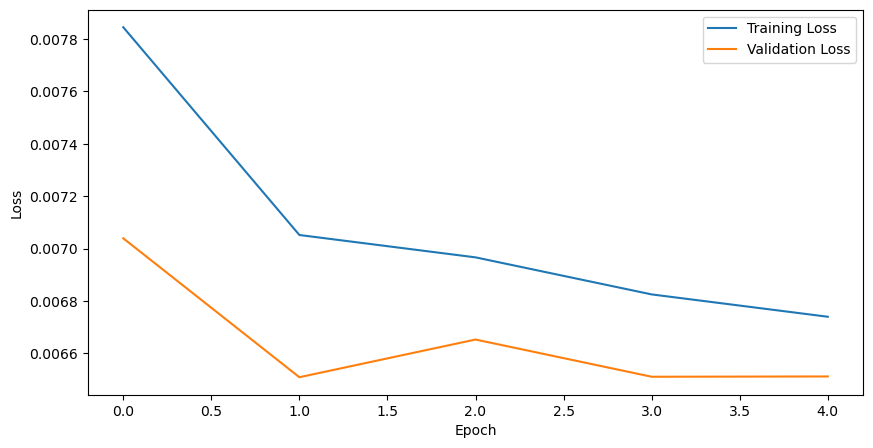

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# from sklearn.metrics import precision_recall_fscore_support, accuracy_score, hamming_loss

# on utilise precision_recall_fscore_support pour calculer les scores de précision, recall et f1-score (multi-label)
# accuracy_score pour calculer l'accuracy (multi-label) 
# hamming_loss pour calculer la hamming loss (multi-label)

# on utilise classification_report pour afficher les résultats
# on utilise multilabel_confusion_matrix pour afficher les matrices

# Test the model
model.eval()
test_loss = 0
test_losses = []
perc_names = []
# confusion matrix for multilabel classification
# correct = 0
# total = 0
# all_preds = []
# all_labels = []

test_bar = tqdm(test_loader, desc=f"Testing Loss: {test_loss:.4f}", colour='red')
with torch.no_grad():
    for i, batch in enumerate(test_bar):
        # Move data to device
        mixture = batch['mixture_audio'].to(device)
        # mix_stft = batch['mix_stft'].to(device)
        true_percussion = batch['percussion_audio'].to(device)
        perc_names = batch['perc_name']
        # true_percussion_stft = batch['perc_stft'].to(device)
        # true_class = batch['noise_labels'].to(device)

        # Forward pass
        # output, class_output = model(torch.abs(mix_stft))
        output_waveform = model(mixture)
        output_waveform = output_waveform['waveform']
        
        # Reconstruct the complex spectrogram
        # sep_output = SpectrogramReconstructor().reconstruct(
        #     output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
        # # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

        # Calculate the loss
        # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
        # loss = criterion(sep_output, class_output, true_percussion_stft,
        #                  true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

        loss = criterion(output_waveform, true_percussion)
        test_loss += loss.item()

        # Calculate multi-label classification accuracy
        # predicted = (torch.sigmoid(class_output) > 0.5).float()
        # # Total for a multi-label classification:
        # total += true_class.size(0) * true_class.size(1)
        # correct += (predicted == true_class).float().sum().item()

        # all_preds.extend(predicted.cpu().numpy())
        # all_labels.extend(true_class.cpu().numpy())

        test_bar.set_description(
            f"Testing Loss: {test_loss/(i+1):.4f}")

    test_loss /= len(test_loader)   
    test_losses.append(test_loss)
    # accuracy = correct / total
    
    # concatenate the names of the percussions
    perc_names = [item for sublist in perc_names for item in sublist]
    
    perc_names = np.array(perc_names)

Testing Loss: 0.0069: 100%|██████████| 121/121 [02:55<00:00,  1.45s/it]


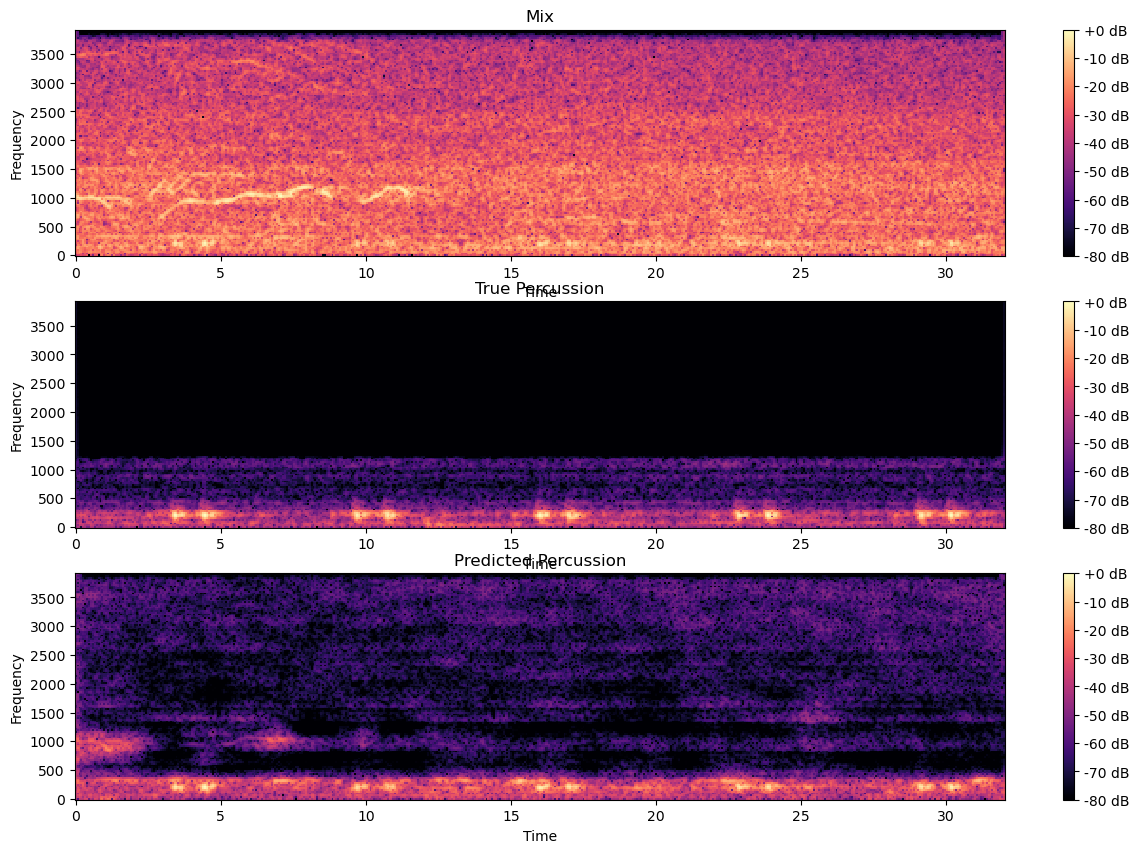

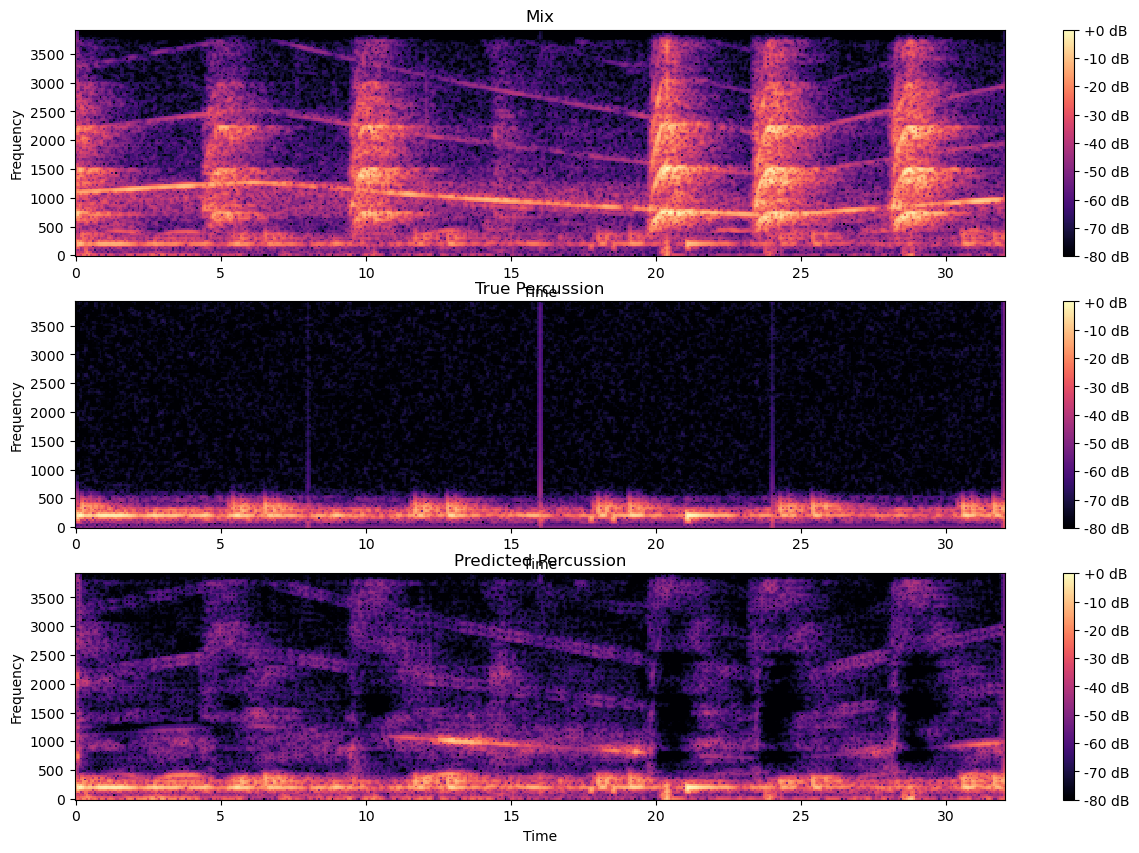

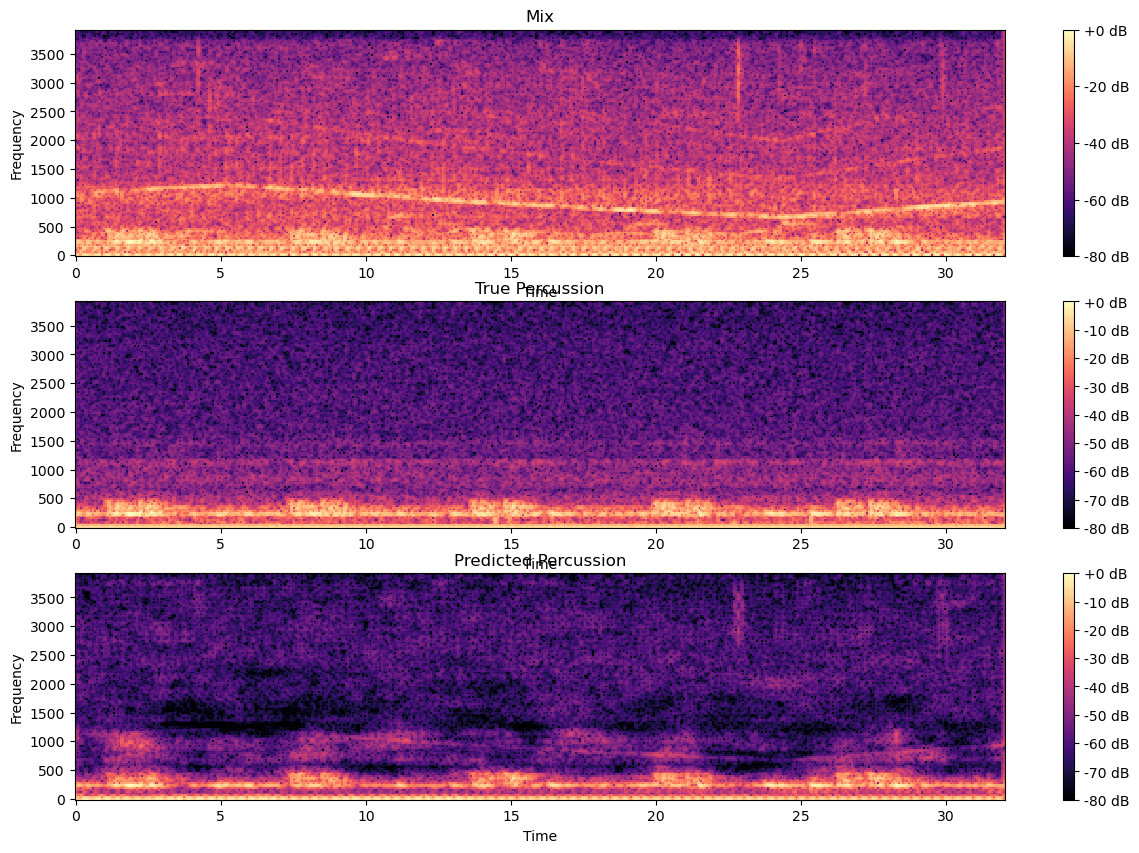

In [ ]:
# plot spectrograms

for i in range(30):
    plt.figure(figsize=(15, 10))

    plt.subplot(3, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(
        np.abs(librosa.stft(mixture[i, 0].cpu().numpy(), n_fft=256, hop_length=64)), ref=np.max), y_axis='linear', x_axis='time', sr=7812)

    plt.colorbar(format='%+2.0f dB')
    plt.title('Mix')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 2)
    librosa.display.specshow(librosa.amplitude_to_db(
        np.abs(librosa.stft(true_percussion[i, 0].cpu().numpy(), n_fft=256, hop_length=64)), ref=np.max), y_axis='linear', x_axis='time', sr=7812)

    plt.colorbar(format='%+2.0f dB')
    plt.title('True Percussion')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.subplot(3, 1, 3)
    librosa.display.specshow(librosa.amplitude_to_db(
        np.abs(librosa.stft(output_waveform[i, 0].cpu().numpy(), n_fft=256, hop_length=64)), ref=np.max), y_axis='linear', x_axis='time', sr=7812)

    plt.colorbar(format='%+2.0f dB')
    plt.title('Predicted Percussion')
    plt.xlabel('Time')
    plt.ylabel('Frequency')

    plt.tight_layout
    plt.show()

    if i ==2 :
        break